# Importing Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
import classes.file_loader as file_loader
import classes.linear_time_series as linear_time_series

# Data Preprocessing

## Loading Files

In [3]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [4]:
classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  classic_raw_df.fillna(method = "ffill", inplace=True)
c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precarity_raw_df.fillna(method = "ffill", inplace=True)


In [5]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [6]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [7]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.174503
2,2023-04-26,7.238924
3,2023-04-27,7.224501
4,2023-04-28,7.249729
...,...,...
446,2025-01-07,7.969759
447,2025-01-08,7.969839
448,2025-01-09,7.986663
449,2025-01-10,7.988577


In [8]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.289269
2,2023-04-26,7.356632
3,2023-04-27,7.364708
4,2023-04-28,7.404977
...,...,...
446,2025-01-07,9.979466
447,2025-01-08,10.242154
448,2025-01-09,10.089486
449,2025-01-10,10.260741


## Plotting the selected augmented dataframes 

We select one iteration of fir the classic and precarirty dataframe.

In [31]:
classic_df = pd.read_csv("selected_augmented_classic_df.csv")
precarity_df = pd.read_csv("selected_augmented_precarity_df.csv")

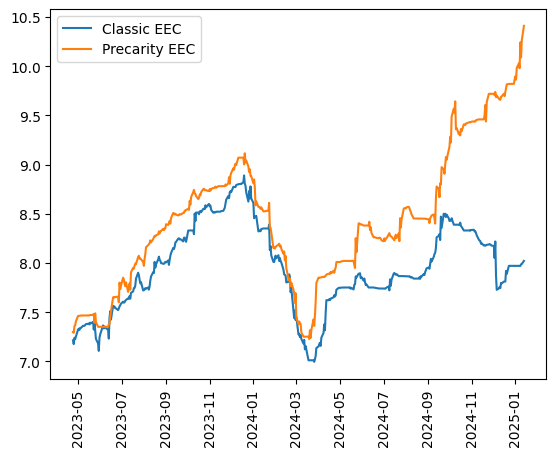

In [32]:
plt.figure()

plt.plot(augmented_classic_df["Date"], augmented_classic_df["SPOT"], label = "Classic EEC")
plt.plot(augmented_precarity_df["Date"], augmented_precarity_df["SPOT"], label = "Precarity EEC")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

# Data forecasting

## Classic EEC

### Tests

#### Stationnarity

From the Graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [33]:
classic_df["Delta"] = classic_df["SPOT"] - classic_df["SPOT"].shift(1)
classic_df.dropna(inplace = True)
classic_df

,Date,SPOT,Delta
1,2023-04-25,7.174503,-0.038213
2,2023-04-26,7.238924,0.064421
3,2023-04-27,7.224501,-0.014423
4,2023-04-28,7.249729,0.025228
5,2023-05-01,7.321166,0.071437
...,...,...,...
446,2025-01-07,7.969759,-0.000241
447,2025-01-08,7.969839,0.000079
448,2025-01-09,7.986663,0.016825
449,2025-01-10,7.988577,0.001914


In [34]:
result = adfuller(classic_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 7.099464000429687e-17
Result: reject unit root -> series is stationary (at 5% level).


We separate trainning and test data to test our models predictions on out of sample data.

### ARIMA

We create an ARMA model (in reality ARIMA as the series wwas already differentiated), using a class built on our own.

In [37]:
# Initiate the ARMA class
LineaTimeSeriesModel = linear_time_series.LineaTimeSeriesModel(classic_df["Delta"])

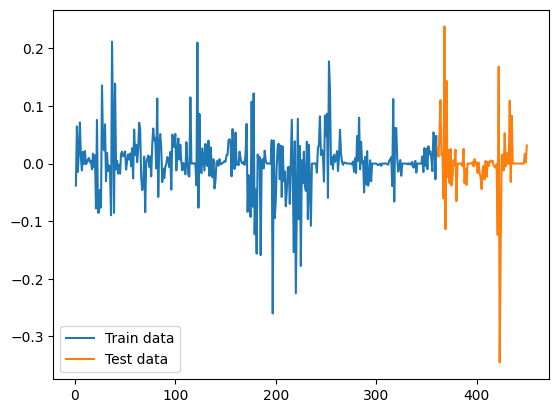

In [38]:
LineaTimeSeriesModel.train_test_split()

plt.figure()
plt.plot(LineaTimeSeriesModel.train_dependent, label="Train data")
plt.plot(LineaTimeSeriesModel.test_dependent, label="Test data")
plt.legend()
plt.show()

In [39]:
# Selecting the last relevant lags
ma_max_order = LineaTimeSeriesModel.get_ma_max_order()
ar_max_order = LineaTimeSeriesModel.get_ar_max_order()
print(f"Max MA order: {ma_max_order}, Max AR order: {ar_max_order}")

Max MA order: 2, Max AR order: 3


Now we select the best model using AIC critertia :

In [40]:
warnings.filterwarnings("ignore")

selected_models = LineaTimeSeriesModel.select_model(ma_max_order, ar_max_order)

The p-value of the L-JungBox test is 5.452188889542694e-05 for the model ARIMA(0,0,0) with AIC = -1144.3101721781136
The p-value of the L-JungBox test is 7.570545478104549e-06 for the model ARIMA(1,0,0) with AIC = -1150.243170534036
The p-value of the L-JungBox test is 0.05929499623878176 for the model ARIMA(2,0,0) with AIC = -1160.409358050496
The p-value of the L-JungBox test is 0.6256113965714318 for the model ARIMA(3,0,0) with AIC = -1166.9177317642766
The p-value of the L-JungBox test is 1.6148356721592134e-05 for the model ARIMA(0,0,1) with AIC = -1147.9394708034883
The p-value of the L-JungBox test is 7.367106984500183e-05 for the model ARIMA(1,0,1) with AIC = -1152.116042331536
The p-value of the L-JungBox test is 0.8410019826228228 for the model ARIMA(2,0,1) with AIC = -1167.1334826325115
The p-value of the L-JungBox test is 0.8983060419302107 for the model ARIMA(3,0,1) with AIC = -1168.2148079677158
The p-value of the L-JungBox test is 0.15325935502114954 for the model ARIMA(

In [41]:
selected_models["aic"]

{'order': (3, 0, 1),
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x1aa5262b110>,
 'aic': np.float64(-1168.2148079677158)}

### LSTM

### GRU

## Precarity EEC

### Test

In [35]:
precarity_df = augmented_precarity_df.copy()
precarity_df["Delta"] = precarity_df["SPOT"] - precarity_df["SPOT"].shift(1)
precarity_df.dropna(inplace = True)
precarity_df

,Date,SPOT,Delta
1,2023-04-25,7.289269,-0.007514
2,2023-04-26,7.356632,0.067363
3,2023-04-27,7.364708,0.008076
4,2023-04-28,7.404977,0.040269
5,2023-05-01,7.460184,0.055207
...,...,...,...
446,2025-01-07,9.979466,-0.050534
447,2025-01-08,10.242154,0.262688
448,2025-01-09,10.089486,-0.152668
449,2025-01-10,10.260741,0.171255


In [36]:
result = adfuller(precarity_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 8.585312912643886e-15
Result: reject unit root -> series is stationary (at 5% level).
